# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In [1]:
!pip install sagemaker==1.72.0

# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
pd.set_option('display.max_colwidth', 100)
import pickle
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import os

# magic word for producing visualizations in notebook
%matplotlib inline

     |████████████████████████████████| 297 kB 19.7 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=e064899b9368b2a7cf27a9beb8e4bbed27ed1db992df7ed5bfe4e7eb44c8609d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.0
    Uninstalling smdebug-rulesconfig-1.0.0:
      Successfully uninstalled smdebug-rulesconfig-1.0.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.19.0
    Uninstalling sagemaker-2.19.0:
      Successfully uninstalled sagemaker-2.19.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

## Part 0: Get to Know the Data And Preprocessing

In [3]:
genpop_file = 'Udacity_AZDIAS_052018.csv'
cust_file = 'Udacity_CUSTOMERS_052018.csv'
train_file = 'Udacity_MAILOUT_052018_TRAIN.csv'
test_file = 'Udacity_MAILOUT_052018_TEST.csv'

In [83]:
def read_file(filename):
    return pd.read_csv('s3://{}/{}'.format(bucket, filename), sep = ';')

In [108]:
%%time

genpop = read_file(genpop_file)
customers = read_file(cust_file)
train = read_file(train_file)
test = read_file(test_file)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


CPU times: user 33.7 s, sys: 3.46 s, total: 37.2 s
Wall time: 1min 5s


First we need to answer the following questions:

- how much data is missing in each column?
- which columns are irredeemable and need to removed
- which columns with missing data will we keep but fill in their NaNs
- which are the final columns that we will use PCA on

In [6]:
datasets = {
    'genpop':genpop,
    'customers':customers,
    'train':train,
    'test':test
}

In [7]:
def count_na(df):
    '''
    Counts the number of missing values of each column as a percentage
    '''
    series = df.isna().sum()/len(df)
    return series

Visualizing how many missing values we have to deal with and if their distribution is the same across other datasets

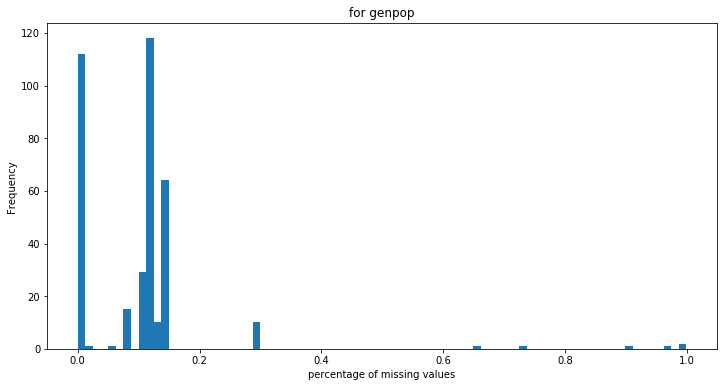

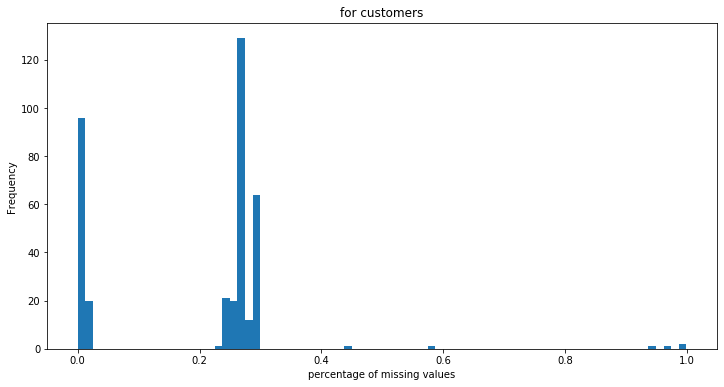

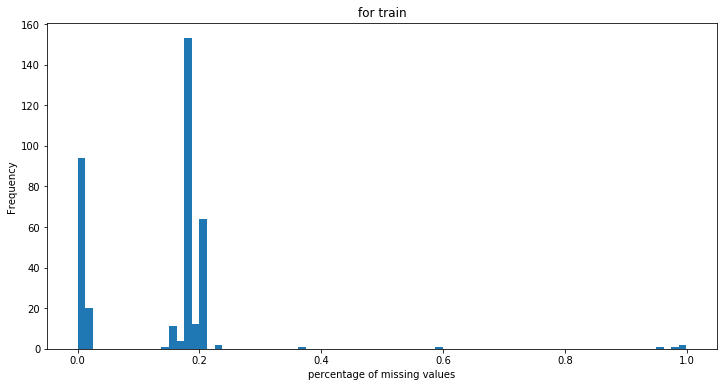

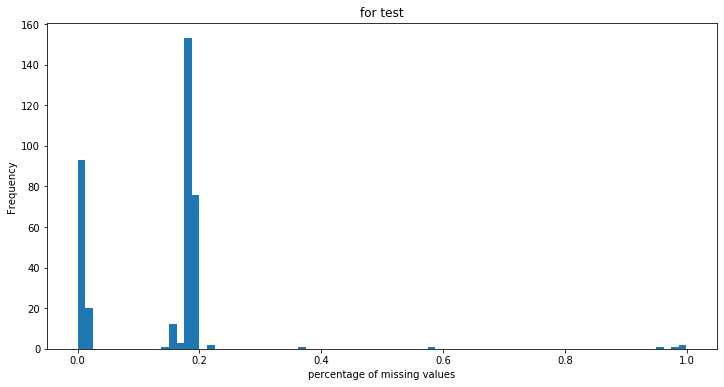

In [8]:
for name, data in datasets.items():
    plt.figure(figsize = (12, 6))
    data_miss = count_na(data)
    count_na(data).plot(kind = 'hist', bins = 80)
    plt.xlabel('percentage of missing values')
    plt.title('for '+name)

del datasets, data #to free up memory

Removing any columns missing with missing data more than 20% makes sense because any more than that might be too much to deal with.
We will use the train dataset to test out and set up our cleaning functions.

In [9]:
missing = count_na(train)
notmiss = list(missing[missing<0.20].index)
clean = train[notmiss]

del missing, notmiss

In [10]:
clean.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,...,4.0,2.0,1.0,1.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,8.0,2.0,0.0,0.0,1.0,1.0,...,1.0,6.0,6.0,3.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,0.0,1.0,1.0,1.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


In [11]:
clean.dtypes.value_counts()

float64    195
int64       94
object       6
dtype: int64

In [12]:
clean[clean.dtypes[clean.dtypes=='object'].index].head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
5,7B,7,41,D19_BUCH_CD,1992-02-10 00:00:00,W
6,4C,4,24,D19_UNBEKANNT,1992-02-10 00:00:00,W
7,5C,5,33,D19_BEKLEIDUNG_GEH,1997-07-18 00:00:00,W
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


These are the few columns that were given a dtype of 'object'. This would mean that most of these should be categorical variables, with the exeption of EINGEFUEGT_AM, which clearly is a columns of dates

In [13]:
set(customers.columns) - set(train.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [14]:
set(customers.columns) - set(genpop.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

These 3 columns are only available in the customers dataset. Let's see them in more detail:

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

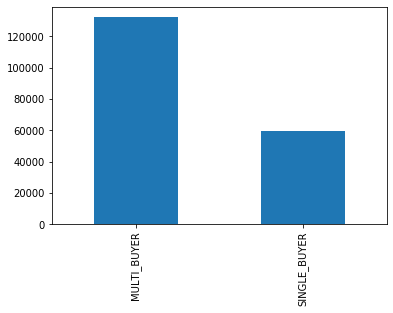

In [15]:
customers.CUSTOMER_GROUP.value_counts(dropna=False).plot( kind = 'bar')
customers.CUSTOMER_GROUP.value_counts(dropna=False)

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

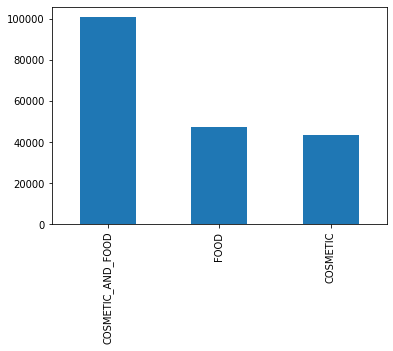

In [16]:
customers.PRODUCT_GROUP.value_counts(dropna=False).plot( kind = 'bar')
customers.PRODUCT_GROUP.value_counts(dropna=False)

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

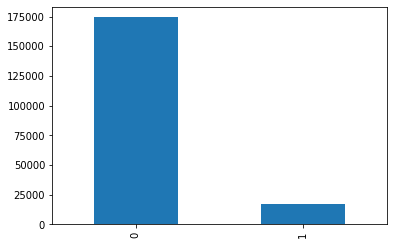

In [17]:
customers.ONLINE_PURCHASE.value_counts(dropna=False).plot( kind = 'bar')
customers.ONLINE_PURCHASE.value_counts(dropna=False)

While this seems very intersting, especially how most of the purchases are made offline, we can't make much use of them in our machine learning later on.

Let's get to know more about the columns were are using

In [18]:
overview = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx', index_col=0, header=1)

In [19]:
details = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', index_col=0, header=1)
details = details.dropna(subset=['Attribute'])

In [20]:
overview.shape

(313, 4)

In [21]:
details.shape

(314, 4)

In [22]:
overview.head(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey
NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data
NaN,NaN,ANREDE_KZ,gender,NaN
NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as the..."
NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ...
NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [23]:
details.head(10)

,Attribute,Description,Value,Meaning
NaN,AGER_TYP,best-ager typology,-1,unknown
NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
NaN,ALTER_HH,main age within the household,0,unknown / no main age detectable
NaN,ANREDE_KZ,gender,"-1, 0",unknown
NaN,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)
NaN,ANZ_HH_TITEL,number of academic title holder in building,…,numeric value (typically coded from 1-10)
NaN,ANZ_PERSONEN,number of adult persons in the household,…,numeric value (typically coded from 1-3)
NaN,ANZ_TITEL,number of professional title holder in household,…,numeric value (typically coded from 1-10)
NaN,BALLRAUM,distance to next urban centre,-1,unknown
NaN,BIP_FLAG,business-flag indicating companies in the building,-1,unknown


In [24]:
overview['Information level'].value_counts(dropna=False)

NaN                   303
Community               1
Building                1
Postcode                1
RR1_ID                  1
Microcell (RR3_ID)      1
PLZ8                    1
125m x 125m Grid        1
Household               1
Person                  1
Microcell (RR4_ID)      1
Name: Information level, dtype: int64

Informational Level is too empty to use

In [25]:
details[details.Attribute.isin(overview.Attribute)].shape

(300, 4)

Most of the rows in overview are available in the details dataframe. Let's check out the ones that are different:

In [26]:
details[~details.Attribute.isin(overview.Attribute)] # rows in details but not in overivew

,Attribute,Description,Value,Meaning
NaN,BIP_FLAG,business-flag indicating companies in the building,-1,unknown
NaN,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
NaN,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
NaN,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12 months,0,no transactions known
NaN,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24 months,0,no transactions known
NaN,D19_LOTTO_RZ,transactional activity based on the product group LOTTO,0,no transaction known
NaN,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known
NaN,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known
NaN,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12 months,0,no transactions known
NaN,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24 months,0,no transactions known


In [27]:
overview[~overview.Attribute.isin(details.Attribute)] # rows in overview but not in details

,Information level,Attribute,Description,Additional notes
NaN,NaN,D19_GESAMT_ANZ_12 D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 12 and 24 months,NaN
NaN,NaN,D19_BANKEN_ ANZ_12 D19_BANKEN_ ANZ_24,transaction activity BANKS in the last 12 and 24 months,NaN
NaN,NaN,D19_TELKO_ ANZ_12 D19_TELKO_ ANZ_24,transaction activity TELCO in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSI_ ANZ_12 D19_VERSI_ ANZ_24,transaction activity INSURANCE in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSAND_ ANZ_12 D19_VERSAND_ ANZ_24,transaction activity MAIL-ORDER in the last 12 and 24 months,NaN
NaN,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segment insurance OFFLINE,NaN
NaN,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segment insurance ONLINE,NaN
NaN,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segment insurance TOTAL,NaN
NaN,NaN,PLZ,postcode,NaN
NaN,NaN,PLZ8,sub-postcode (about 8 PLZ8 make up one PLZ) and \nnew macrocell level (about 500 households),NaN


Both dataframes have a few rows that the other doesn't have. So, it is useful to use them both together.

In [28]:
info = overview.merge(details, how = 'outer').drop(['Information level'],axis=1)
info.head(10)

,Attribute,Description,Additional notes,Value,Meaning
0,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,-1,unknown
1,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-reference data,NaN,NaN
2,ANREDE_KZ,gender,NaN,"-1, 0",unknown
3,CJT_GESAMTTYP,Customer-Journey-Typology relating to the preferred information and buying channels of consumers,"relating to the preferred information, marketing and buying channels of consumers as well as the...",NaN,NaN
4,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative household panel combined via a statistical modell with AZ...,-1,unknown
5,FINANZ_SPARER,financial typology: money saver,NaN,-1,unknown
6,FINANZ_VORSORGER,financial typology: be prepared,NaN,-1,unknown
7,FINANZ_ANLEGER,financial typology: investor,NaN,-1,unknown
8,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN,-1,unknown
9,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN,-1,unknown


In [29]:
info.Attribute.duplicated().sum()

50

In [30]:
info = info.drop_duplicates(subset='Attribute')

In [31]:
info.shape

(327, 5)

In [32]:
info_clean = info[info.Attribute.isin(clean.columns)] # focusing on only the columns we will be using
print(info_clean.shape)

(211, 5)


In [33]:
for _, row in info_clean.sort_values('Attribute').iterrows():
    print('{}: {}'.format(row.iloc[0], row.iloc[1]))
    print()
#     break

AGER_TYP: best-ager typology

ALTERSKATEGORIE_GROB: age through prename analysis 

ALTER_HH: main age within the household

ANREDE_KZ: gender

ANZ_HAUSHALTE_AKTIV: number of households known in this building

ANZ_HH_TITEL: number of holders of an academic title in the building

ANZ_PERSONEN: number of persons known in this household

ANZ_TITEL: number of bearers of an academic title within this household

ARBEIT: share of unemployed person in the community

BALLRAUM: distance to the next metropole

CAMEO_DEUG_2015: CAMEO_4.0: uppergroup

CAMEO_DEU_2015: CAMEO_4.0: specific group

CJT_GESAMTTYP: Customer-Journey-Typology relating to the preferred information and buying channels of consumers

D19_BANKEN_ANZ_12: transaction activity BANKS in the last 12 months

D19_BANKEN_ANZ_24: transaction activity BANKS in the last 24 months

D19_BANKEN_DATUM: actuality of the last transaction for the segment banks TOTAL

D19_BANKEN_OFFLINE_DATUM: actuality of the last transaction for the segment banks

After some reading of the above, we can see that most of the columns consist of the following information:

- household
- transactional activity (columns starting with D19)
- Cars (columns starting with KBA13)
- PLZ8 demographics
- financial typology(columns starting with FINANZ)
- mindedness (columns starting with SEMIO)

In [34]:
def print_columns_containing(code):
    perc = (1 - info_clean.Attribute.apply(lambda x: x if code in x else 'other'
                                  ).value_counts(normalize=True).iloc[0]).round(4)*100
    print(code, perc)
    return perc

In [35]:
codes = {}
total = 0
for code in ['D19','KBA13','SEMIO', 'FINANZ']:
    codes[code] = print_columns_containing(code)
    total+= codes[code]
codes['other'] = 100-total

D19 13.74
KBA13 50.71
SEMIO 6.64
FINANZ 3.32


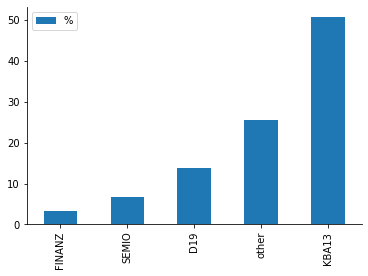

In [36]:
pd.DataFrame(codes, index=['%']).T.sort_values('%').plot(kind='bar')
sns.despine()

We can see that a huge number of the columns (over 50% of train dataset) is comprised of car data.

Transactional data, which is probably more relevant than cars to our project, consists of only 13.74% of the columns available in the train dataset.

In [37]:
clean.isna().sum()[clean.isna().sum()>0].shape

(201,)

We still have 201 columns with missing values that we need to deal with

In [38]:
clean.dtypes.value_counts()

float64    195
int64       94
object       6
dtype: int64

Let's deal with objects first

In [39]:
objects = clean.select_dtypes(include=['object'])
obj_cols = objects.columns
objects.head(10)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W
1,5B,5,32,D19_TELKO_MOBILE,1997-05-14 00:00:00,W
2,2D,2,14,D19_LEBENSMITTEL,1995-05-24 00:00:00,O
3,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
4,7B,7,41,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
5,7B,7,41,D19_BUCH_CD,1992-02-10 00:00:00,W
6,4C,4,24,D19_UNBEKANNT,1992-02-10 00:00:00,W
7,5C,5,33,D19_BEKLEIDUNG_GEH,1997-07-18 00:00:00,W
8,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
for column in objects.columns:
    print('Number of unique values for {}:'.format(column), objects[column].nunique())
    print()

Number of unique values for CAMEO_DEU_2015: 45

Number of unique values for CAMEO_DEUG_2015: 19

Number of unique values for CAMEO_INTL_2015: 43

Number of unique values for D19_LETZTER_KAUF_BRANCHE: 35

Number of unique values for EINGEFUEGT_AM: 1599

Number of unique values for OST_WEST_KZ: 2



In [41]:
objects.isna().sum() / len(objects)

CAMEO_DEU_2015              0.183604
CAMEO_DEUG_2015             0.183604
CAMEO_INTL_2015             0.183604
D19_LETZTER_KAUF_BRANCHE    0.176528
EINGEFUEGT_AM               0.181020
OST_WEST_KZ                 0.181020
dtype: float64

In [42]:
objects.columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

In [43]:
details[details.Attribute.isin(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'])]

,Attribute,Description,Value,Meaning
NaN,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
NaN,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,1A,Work-Life-Balance
NaN,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown


We didn't get details of all the oclumns, but we can see that CAMEO_DEU is the same as CAMEO_DEUG, so we can just remove one of them. We'll choose to keep CAMEO_DEUG, since it has less unique values.

Similarly, we can't take the date column as it is. Let's try splitting it into Year-Month values:

In [44]:
objects['EINGEFUEGT_AM'].apply(lambda date: '-'.join(str(date).split('-')[0:2])).nunique()

262

262 are too many unique values - so we have to group them into just Years instead:

In [45]:
objects['date'] = objects['EINGEFUEGT_AM'].apply(lambda date: date.split('-')[0] if  date is not np.nan else date)
objects.date.nunique()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


25

In [46]:
objects.date.value_counts().sort_index()

1991        1
1992    26425
1993     1188
1994     1398
1995     1900
1996     1350
1997      866
1998      154
1999       33
2000      218
2001       59
2002      121
2003      333
2004      223
2005      350
2006      144
2007       92
2008       73
2009       65
2010       29
2011       41
2012       47
2013       29
2014       30
2015       16
Name: date, dtype: int64

It appears this data is split up over 25 years, with only 1 values in the first year (1991), and last year being 2015.

In [47]:
objects = objects.drop(['CAMEO_DEU_2015','EINGEFUEGT_AM'], axis=1)

In [48]:
objects.head(10)

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5,34,D19_UNBEKANNT,W,1992
1,5,32,D19_TELKO_MOBILE,W,1997
2,2,14,D19_LEBENSMITTEL,O,1995
3,2,14,D19_UNBEKANNT,W,1992
4,7,41,D19_BEKLEIDUNG_GEH,W,1992
5,7,41,D19_BUCH_CD,W,1992
6,4,24,D19_UNBEKANNT,W,1992
7,5,33,D19_BEKLEIDUNG_GEH,W,1997
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [49]:
objects.mode().iloc[0]

CAMEO_DEUG_2015                         6
CAMEO_INTL_2015                        24
D19_LETZTER_KAUF_BRANCHE    D19_UNBEKANNT
OST_WEST_KZ                             W
date                                 1992
Name: 0, dtype: object

In [50]:
objects.memory_usage(index=False, deep=True)

CAMEO_DEUG_2015             1635486
CAMEO_INTL_2015             1645513
D19_LETZTER_KAUF_BRANCHE    2766207
OST_WEST_KZ                 2289594
date                        2395149
dtype: int64

In [51]:
objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']] = \
objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']].apply(lambda df: pd.to_numeric(df, errors='coerce'))

In [52]:
objects = objects.fillna(objects.mode().iloc[0]).astype('category')

In [53]:
objects.memory_usage(index=False, deep=True)

CAMEO_DEUG_2015             43354
CAMEO_INTL_2015             43770
D19_LETZTER_KAUF_BRANCHE    46737
OST_WEST_KZ                 43158
date                        43802
dtype: int64

By changing from object to category dtype, we have drastically reduced the amount of memeory used

In [54]:
objects.head(10)

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5.0,34.0,D19_UNBEKANNT,W,1992.0
1,5.0,32.0,D19_TELKO_MOBILE,W,1997.0
2,2.0,14.0,D19_LEBENSMITTEL,O,1995.0
3,2.0,14.0,D19_UNBEKANNT,W,1992.0
4,7.0,41.0,D19_BEKLEIDUNG_GEH,W,1992.0
5,7.0,41.0,D19_BUCH_CD,W,1992.0
6,4.0,24.0,D19_UNBEKANNT,W,1992.0
7,5.0,33.0,D19_BEKLEIDUNG_GEH,W,1997.0
8,6.0,24.0,D19_UNBEKANNT,W,1992.0
9,6.0,24.0,D19_UNBEKANNT,W,1992.0


In [55]:
objects.isna().sum()

CAMEO_DEUG_2015             0
CAMEO_INTL_2015             0
D19_LETZTER_KAUF_BRANCHE    0
OST_WEST_KZ                 0
date                        0
dtype: int64

Good. Now that there are no more empty values. We need to change our categorical values to numbers

In [56]:
objects.CAMEO_DEUG_2015.value_counts(dropna=False)

6.0    13262
4.0     5131
8.0     5010
2.0     4703
3.0     4423
7.0     3064
5.0     2531
9.0     2460
1.0     2378
Name: CAMEO_DEUG_2015, dtype: int64

Need to remove those .0s

In [57]:
def remove_point0(df, col):
    return df[col].apply(lambda x: str(x).split('.')[0])

In [58]:
for col in objects.columns:
    objects[col] = remove_point0(objects, col)

In [59]:
objects.head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ,date
0,5,34,D19_UNBEKANNT,W,1992
1,5,32,D19_TELKO_MOBILE,W,1997
2,2,14,D19_LEBENSMITTEL,O,1995
3,2,14,D19_UNBEKANNT,W,1992
4,7,41,D19_BEKLEIDUNG_GEH,W,1992


Now we're ready to change them to dummies!

In [60]:
objects_touse = pd.get_dummies(objects, drop_first=True)

In [61]:
del objects

In [62]:
objects_touse.head()

,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_INTL_2015_13,CAMEO_INTL_2015_14,...,date_2006,date_2007,date_2008,date_2009,date_2010,date_2011,date_2012,date_2013,date_2014,date_2015
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now that we're done with the objects, time to look at the numeric columns

In [63]:
numbers = clean.loc[:, ~clean.columns.isin(obj_cols)]

In [64]:
numbers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,2.0,5.0,2.0,1.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,3.0,1.0,2.0,1.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,...,1.0,6.0,4.0,2.0,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,4.0,8.0,11.0,11.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,4.0,2.0,2.0,1.0,9.0,3.0,3,0,1,3


In [65]:
numbers['LNR'].nunique()

42962

In [66]:
numbers.shape

(42962, 289)

LNR is unique to each row so it is clearly an ID number. Since ids are meaningless to us, we'll remove it

In [67]:
numbers = numbers.drop('LNR',axis=1)

In [68]:
numbers.memory_usage(index=False)

AGER_TYP                343696
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                343696
RESPONSE                343696
ANREDE_KZ               343696
ALTERSKATEGORIE_GROB    343696
Length: 288, dtype: int64

We can't do much with such a huge memory size, so let's reduce it. But first, we'll take a look at the unique numbers.

In [69]:
unis = numbers.nunique()

In [70]:
unis.head(20)

AGER_TYP                        5
AKT_DAT_KL                      9
ALTER_HH                       20
ALTERSKATEGORIE_FEIN           25
ANZ_HAUSHALTE_AKTIV           175
ANZ_HH_TITEL                   15
ANZ_KINDER                      7
ANZ_PERSONEN                   14
ANZ_STATISTISCHE_HAUSHALTE    173
ANZ_TITEL                       3
ARBEIT                          6
BALLRAUM                        7
CJT_GESAMTTYP                   6
CJT_KATALOGNUTZER               5
CJT_TYP_1                       5
CJT_TYP_2                       5
CJT_TYP_3                       5
CJT_TYP_4                       5
CJT_TYP_5                       5
CJT_TYP_6                       5
dtype: int64

In [71]:
numbers.shape

(42962, 288)

In [72]:
unis[unis<20].shape #seeing without outliers

(278,)

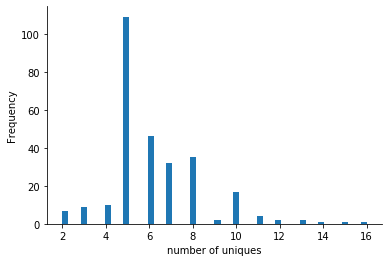

In [73]:
unis[unis<20].plot(kind='hist',bins=50)
plt.xlabel('number of uniques')
sns.despine()

We can see that a large number of our supposedly numeric columns have only 5 or less unique numbers. This could suggest that these columns might actually be categorical instead. Let's check:

In [74]:
overview[overview.Attribute.isin(unis[unis==5].index)].tail(10)

,Information level,Attribute,Description,Additional notes
NaN,NaN,KBA13_VORB_0,share of cars with no preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_1,share of cars with 1 preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_1_2,share of cars with 1 or 2 preowner - PLZ8,NaN
NaN,NaN,KBA13_VORB_2,share of cars with 2 preowner - PLZ8,NaN
NaN,NaN,KBA13_VW,share of VOLKSWAGEN within the PLZ8,NaN
NaN,NaN,PLZ8_ANTG1,number of 1-2 family houses in the PLZ8,NaN
NaN,NaN,PLZ8_ANTG2,number of 3-5 family houses in the PLZ8,NaN
NaN,NaN,PLZ8_BAUMAX,most common building-type within the PLZ8,NaN
NaN,NaN,PLZ8_HHZ,number of households within the PLZ8,NaN
NaN,NaN,PLZ8_GBZ,number of buildings within the PLZ8,NaN


Looking at it here, it seems that assumption was not exactly correct. For example, for number of family houses, 3 is more 2, which is more than 1. That can't be a categorical variable and should stay as numeric to keep that kind of information. The kind that says that some people have more than others. You can't do that with a categorical variable. So, let's move on.

In [75]:
del unis

In [76]:
def reduce_memory_nums(df):
    for col in df.columns:
#         print(col)

        mx = df[col].max()
        mn = df[col].min()

        if mn >= 0:
            if mx < 255:
                df[col] = df[col].astype(np.uint8, errors='ignore')
            elif mx < 65535:
                df[col] = df[col].astype(np.uint16, errors='ignore')
            elif mx < 4294967295:
                df[col] = df[col].astype(np.uint32, errors='ignore')
            else:
                df[col] = df[col].astype(np.uint64, errors='ignore')
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8, errors='ignore')
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16, errors='ignore')
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32, errors='ignore')
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64, errors='ignore')
    return df

In [77]:
#         df[col] = df[col].apply(lambda s: pd.to_numeric(s, errors='coerce'))
#         df[col] = df[col].fillna(df[col].median())

In [78]:
numbers.memory_usage(index=False)

AGER_TYP                343696
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                343696
RESPONSE                343696
ANREDE_KZ               343696
ALTERSKATEGORIE_GROB    343696
Length: 288, dtype: int64

In [79]:
numbers = reduce_memory_nums(numbers)

In [80]:
numbers.memory_usage(index=False)

AGER_TYP                 42962
AKT_DAT_KL              343696
ALTER_HH                343696
ALTERSKATEGORIE_FEIN    343696
ANZ_HAUSHALTE_AKTIV     343696
                         ...  
WOHNLAGE                343696
ZABEOTYP                 42962
RESPONSE                 42962
ANREDE_KZ                42962
ALTERSKATEGORIE_GROB     42962
Length: 288, dtype: int64

In [81]:
numbers.isna().sum().sum()

1387396

In [82]:
# numbers = numbers.apply(lambda s: pd.to_numeric(s, errors='coerce'))
numbers = numbers.fillna(numbers.median().iloc[0])

In [83]:
numbers.isna().sum().sum()

0

In [84]:
numbers = reduce_memory_nums(numbers)

In [85]:
numbers.memory_usage(index=False)

AGER_TYP                42962
AKT_DAT_KL              42962
ALTER_HH                42962
ALTERSKATEGORIE_FEIN    42962
ANZ_HAUSHALTE_AKTIV     85924
                        ...  
WOHNLAGE                42962
ZABEOTYP                42962
RESPONSE                42962
ANREDE_KZ               42962
ALTERSKATEGORIE_GROB    42962
Length: 288, dtype: int64

Now we have no more missing values with numbers.
Let's wrap all of these steps in functions and place them all in one place here:

First we'll save the columns we used in clean, so that we can keep the columns constant throughout the datasets:

In [125]:
cols_touse = clean.columns.tolist()
cols_touse.remove('RESPONSE')

In [91]:
def remove_point0(df, col):
    return df[col].apply(lambda x: str(x).split('.')[0])

In [92]:
def clean_objects(df):
    objects = df.select_dtypes(include=['object'])
    obj_cols = objects.columns
    
    objects['EINGEFUEGT_AM'].apply(lambda date: '-'.join(str(date).split('-')[0:2])).nunique()
    objects['date'] = objects['EINGEFUEGT_AM'].apply(lambda date: date.split('-')[0] if  date is not np.nan else date)
    
    objects = objects.drop(['CAMEO_DEU_2015','EINGEFUEGT_AM'], axis=1)
    objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']] = \
    objects[['CAMEO_DEUG_2015','CAMEO_INTL_2015','date']].apply(lambda df: pd.to_numeric(df, errors='coerce'))
    
    objects = objects.fillna(objects.mode().iloc[0]).astype('category')
    
    for col in objects.columns:
        objects[col] = remove_point0(objects, col)
        
    objects_touse = pd.get_dummies(objects, drop_first=True)
    
    return objects_touse, obj_cols

In [93]:
def reduce_memory_nums(df):
    for col in df.columns:
#         print(col)

        mx = df[col].max()
        mn = df[col].min()

        if mn >= 0:
            if mx < 255:
                df[col] = df[col].astype(np.uint8, errors='ignore')
            elif mx < 65535:
                df[col] = df[col].astype(np.uint16, errors='ignore')
            elif mx < 4294967295:
                df[col] = df[col].astype(np.uint32, errors='ignore')
            else:
                df[col] = df[col].astype(np.uint64, errors='ignore')
        else:
            if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8, errors='ignore')
            elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16, errors='ignore')
            elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32, errors='ignore')
            elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64, errors='ignore')
    return df

In [94]:
def clean_numeric(df, obj_cols):
    numbers = df.loc[:, ~df.columns.isin(obj_cols)]
    numbers = numbers.drop('LNR',axis=1)
    
    numbers = reduce_memory_nums(numbers)
    numbers = numbers.fillna(numbers.median().iloc[0])
    numbers = reduce_memory_nums(numbers)
    return numbers

In [191]:
def combine_cleans(df, include_response = False):
    if include_response:
        cols = cols_touse+['RESPONSE']
    else:
        cols = cols_touse
    df = df.loc[:, df.columns.isin(cols)]
    objects, obj_cols = clean_objects(df)
    numbers = clean_numeric(df, obj_cols)
    
    return pd.concat([numbers,objects], axis=1)

In [133]:
%%time

customers = combine_cleans(customers)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 11.2 s, sys: 2.63 s, total: 13.8 s
Wall time: 13.8 s


In [134]:
%%time

genpop = combine_cleans(genpop)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 45.6 s, sys: 42.2 s, total: 1min 27s
Wall time: 1min 27s


In [193]:
%%time

train = combine_cleans(train, include_response=True)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2.68 s, sys: 0 ns, total: 2.68 s
Wall time: 2.68 s


In [185]:
%%time

test = combine_cleans(test)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 2.77 s, sys: 0 ns, total: 2.77 s
Wall time: 2.77 s


In [194]:
train.shape

(42962, 375)

In [186]:
test.shape

(42833, 373)

In [195]:
train.loc[:, ~train.columns.isin(test.columns)]

,RESPONSE,date_1992
0,0,1
1,0,0
2,0,0
3,0,1
4,0,1
...,...,...
42957,0,1
42958,0,1
42959,0,1
42960,0,1


In [199]:
test.loc[:, test.columns.str.contains('date')].columns

Index(['date_1993', 'date_1994', 'date_1995', 'date_1996', 'date_1997',
       'date_1998', 'date_1999', 'date_2000', 'date_2001', 'date_2002',
       'date_2003', 'date_2004', 'date_2005', 'date_2006', 'date_2007',
       'date_2008', 'date_2009', 'date_2010', 'date_2011', 'date_2012',
       'date_2013', 'date_2014', 'date_2015'],
      dtype='object')

We will need to deal with date_1992 when training for predictions later, since it's not available in test dataset.

In [178]:
def save_pickle(data, filename):
    outfile = open(filename,'wb')
    pickle.dump(data, outfile)
    outfile.close()
    print(filename,'saved!')

In [179]:
save_pickle(customers, 'customers.csv')

customers.csv saved!


In [158]:
save_pickle(genpop, 'genpop.csv')

genpop.csv saved!


In [201]:
save_pickle(train, 'train.csv')

train.csv saved!


In [202]:
save_pickle(test, 'test.csv')

test.csv saved!


We will refer to this area as a checkpoint! This means that we can stop here

In [3]:
def load_pickle(filename):
    infile = open(filename,'rb')
    out = pickle.load(infile)
    infile.close()
    print(filename,'loaded!')
    return out

In [8]:
genpop = load_pickle('genpop.csv')
customers = load_pickle('customers.csv')

genpop.csv loaded!
customers.csv loaded!


Next we choose the type of scaler to use.  Standard scaler is better suited if our data is normally distributed and if not MinMax Scaler is better.

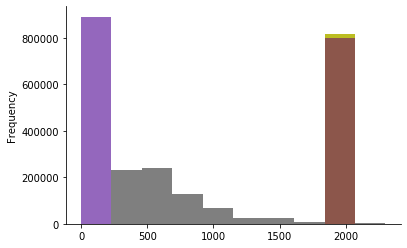

In [9]:
genpop.plot(kind='hist', legend=None)
sns.despine()

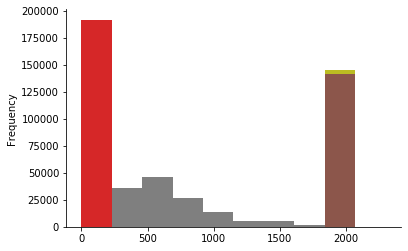

In [10]:
customers.plot(kind='hist', legend=None)
sns.despine()

From these simple plots we can see that MinMax Scaler would be a lot better to use.  We will use Robust Scaler first though to get rid of outliers.

In [9]:
rob = RobustScaler()
scaler = MinMaxScaler()

In [10]:
genpop.shape

(891221, 375)

In [11]:
customers.shape

(191652, 374)

In [12]:
genpop.columns[~genpop.columns.isin(customers.columns)]

Index(['date_1992'], dtype='object')

We will remove 1992 from here too or else we won't be able to use the same scaler for both of these

In [13]:
genpop = genpop.drop('date_1992', axis=1)

In [103]:
%%time

g_array = rob.fit_transform(genpop)
c_array = rob.transform(customers)

CPU times: user 9.44 s, sys: 1.93 s, total: 11.4 s
Wall time: 11.4 s


In [104]:
%%time

g_array = scaler.fit_transform(g_array)
c_array = scaler.transform(c_array)

CPU times: user 2.27 s, sys: 620 ms, total: 2.89 s
Wall time: 2.89 s


## Part 1: Customer Segmentation Report

According to AWS documentation, there is a 60 second timeout when trying to use a model to predict. The problem is that our data is so large, that it needs more time than that for predictions. There is no possible way I could find to increase this limit. I even tried using the "ml.m5.4xlarge" which consists of 16 core processor and 64 GiB Memory. Because of this, we will have to use SKLearn's PCA instead of Sagemaker's.

In [228]:
pca = PCA()

In [229]:
%%time 

g_comp = pca.fit_transform(g_array)

CPU times: user 1min 9s, sys: 3.43 s, total: 1min 13s
Wall time: 14.9 s


In [230]:
(pca.explained_variance_[0:10] / pca.explained_variance_.sum()).sum()

0.5652620642642728

We can see that top 10 components make up 56.5% of our total variance. So let's see how many components we need to get 75%:

In [231]:
for n_top in range(len(g_array)):
    total_var = (pca.explained_variance_[:n_top] / pca.explained_variance_.sum()).sum()
    if total_var >= 0.75:
        break
        
print('Explained Variance is {} with {} components'.format(total_var, n_top))        

Explained Variance is 0.7521851672604789 with 47 components


Let's take a look at the some of the make up of these components

In [189]:
def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_gen -component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [190]:
v = pd.DataFrame(pca.components_)

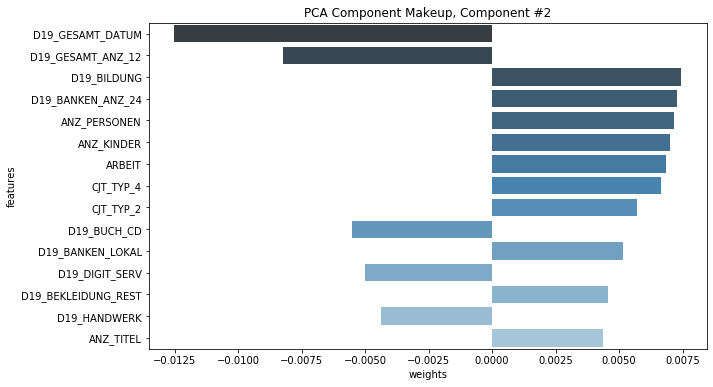

In [200]:
display_component(v,genpop.columns.values, component_num=2, n_weights=15)

This component is mostly made up of D19 features, meaning mostly transactional activity information. There are some ANZ there which is household information.

D19_GESAMT_DATUM, the biggest component translates to "actuality of the last transaction with the complete file TOTAL"

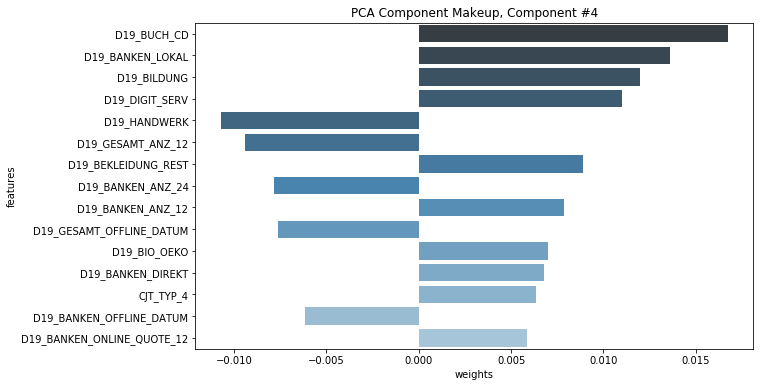

In [202]:
display_component(v,genpop.columns.values, component_num=4, n_weights=15)

This component is almost completely made up of transactional activity too, more than the previous one. I can see a lot of "BANKEN" which means it is related to bank's activity too.

Currently, not all of column meanings are available to me; but I can see that D19_BUCH_CD is having the biggest impact on this component 14.

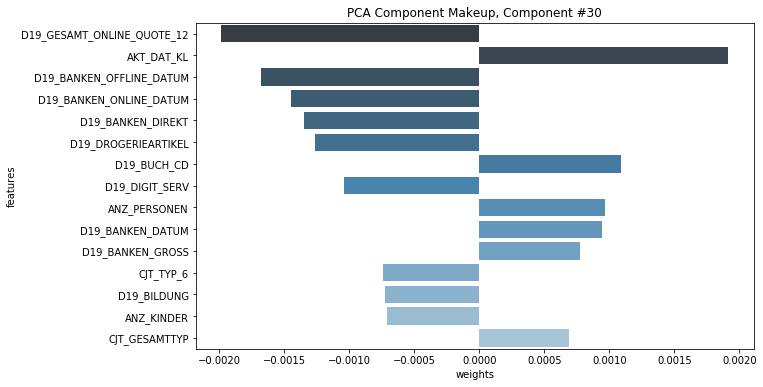

In [218]:
display_component(v,genpop.columns.values, component_num=30, n_weights=15)

This component is having a big impact from D19_GESAMT_ONLINE_QUOTE_12 and AKT_DAT_KL.

Notice how none of these components are heavily influenced by car data (KBA13), even though most of the columns consisted of car data. This makes one argue that we might not need all these car features after all.

Futher on, realistically, we would take these component names and go back to the marketing department or database administrator and have them give us the meanings of each of these feature names so that we know in more detail what exactly these components are made up of.

Now let's create our pca model again but with 47 components only. We will also make sure we are getting the same explained variance number (not % this time)

In [232]:
pca.explained_variance_[:n_top].sum()

18.2679690829616

In [233]:
%%time 

print(n_top)
pca = PCA(n_components=n_top)
g_comp = pca.fit_transform(g_array)

47
CPU times: user 55.8 s, sys: 6.99 s, total: 1min 2s
Wall time: 16.3 s


In [234]:
pca.explained_variance_.sum()

18.23148934032945

Good, we are getting about 18.2 which is the same as our top components from last time.

In [235]:
c_comp = pca.transform(c_array)

After trying out Kmeans, it seems to take too long on our large data. So, we will use MiniBatchKmeans instead

In [249]:
from sklearn.cluster import MiniBatchKMeans

In [252]:
%%time

Ks = range(1, 31)
km = [MiniBatchKMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(g_comp).score(g_comp) for i in range(len(km))]

CPU times: user 5min 24s, sys: 30.5 s, total: 5min 55s
Wall time: 4min 54s


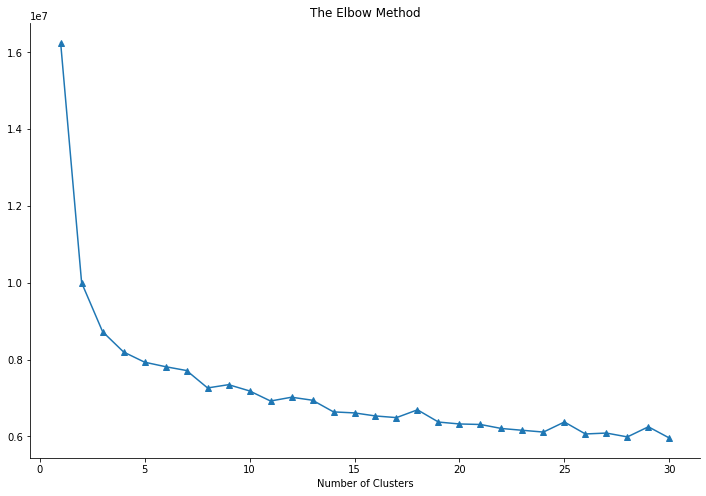

In [266]:
plt.figure(figsize=(12,8))
plt.plot(Ks,  np.abs(score), marker='^')
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
sns.despine()

8 and 11 seem to be good 'elbow' points. We'll go with 11 so as to have more clusters for our large amount of data.

In [350]:
final_kmeans = MiniBatchKMeans(n_clusters=11, random_state=321)
final_kmeans

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=11, n_init=3, random_state=321,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [351]:
%%time
g_clust = final_kmeans.fit_predict(g_comp)

CPU times: user 5 s, sys: 505 ms, total: 5.5 s
Wall time: 4.62 s


In [352]:
%%time
c_clust = final_kmeans.predict(c_comp)

CPU times: user 946 ms, sys: 0 ns, total: 946 ms
Wall time: 945 ms


Now let's see the differences between the our datasets for each cluster

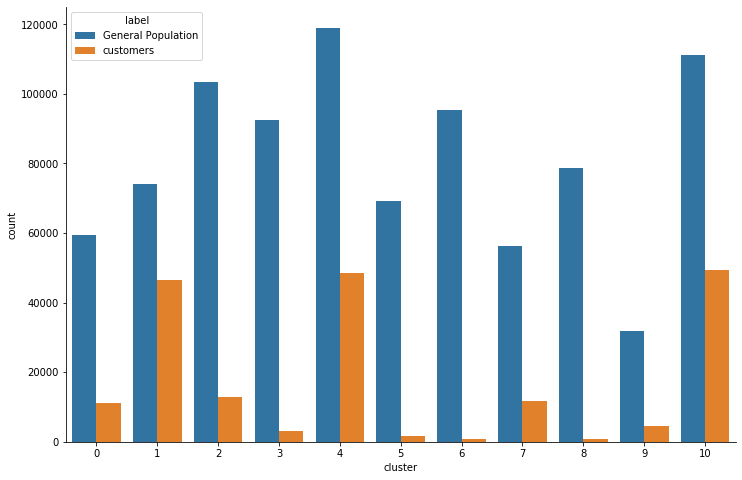

In [353]:
g_df = pd.DataFrame(g_clust, columns = ['cluster'])
g_df['label']='General Population'

c_df = pd.DataFrame(c_clust, columns = ['cluster'])
c_df['label']='customers'

clust_df = g_df.append(c_df)

plt.figure(figsize=(12,8))
sns.countplot(x='cluster',data =clust_df, hue='label')
sns.despine()

We can see that clusters 4, 10 and 1 are the clusters with most counts for both our General population dataset and our customers dataset.
Interestingly, clusters and 8 and 6 are getting very few counts for customers, yet maintain a good number for the general population.

let's compare a few columns and see how they differ between clusters and between our 2 datasets. We will use the median here to avoid outliers and not sum, so that we can balance between the 2 datasets:

In [420]:
comparecols = {
    'ANZ_PERSONEN': 'number of persons known in this household',
    'ALTER_HH': 'main age within the household',
    'ANREDE_KZ': 'gender',
    'KKK': 'purchasing power',
    'D19_VERSAND_ANZ_24':'transaction activity MAIL-ORDER in the last 24 months',
    'KBA13_ANZAHL_PKW': 'number of cars in the PLZ8'
}

In [421]:
def compare_col(col):    
    g_col = pd.concat([genpop[[col]], g_df],axis=1)
    c_col = pd.concat([customers[[col]], c_df],axis=1)
    both = g_col.append(c_col)

    plt.figure(figsize=(12,8))
    sns.barplot(x='cluster', y = col,data =both, hue='label', estimator=np.median)
    plt.title(comparecols[col])
    sns.despine()

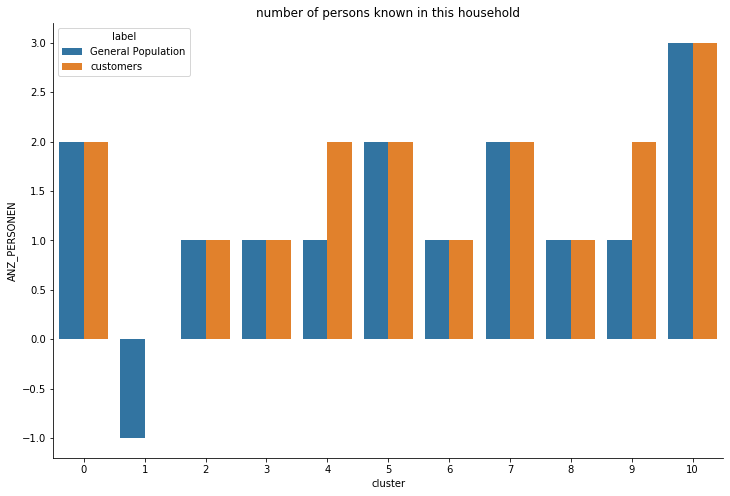

In [422]:
compare_col('ANZ_PERSONEN')

here we can see that both datasets are in a aggrement for cluster 10

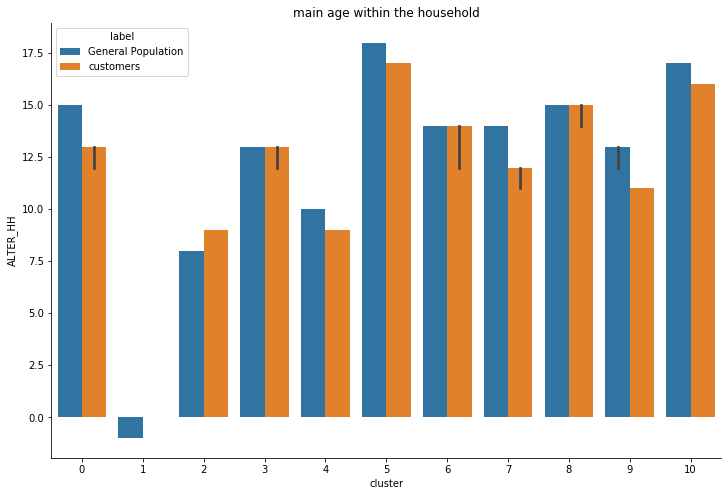

In [423]:
compare_col('ALTER_HH')

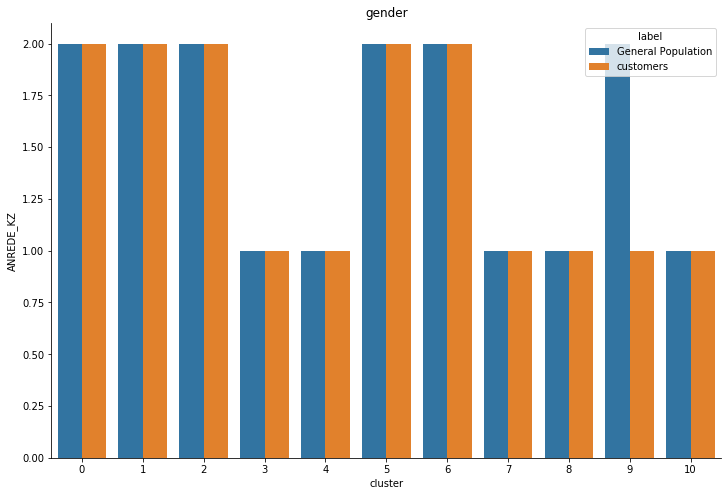

In [424]:
compare_col('ANREDE_KZ')

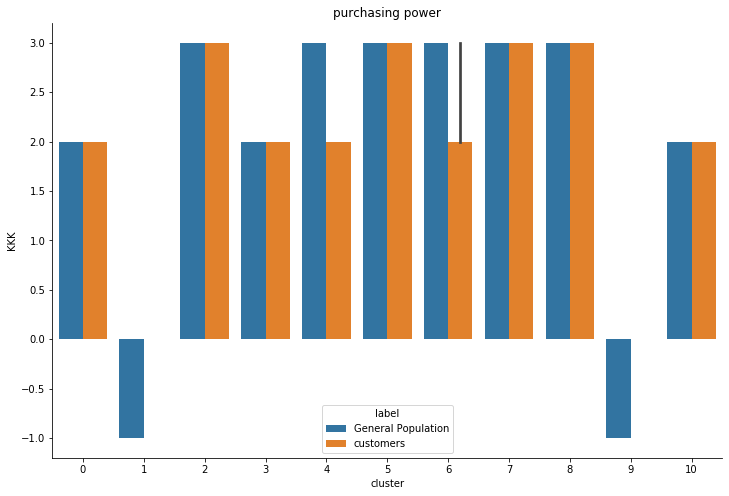

In [425]:
compare_col('KKK')

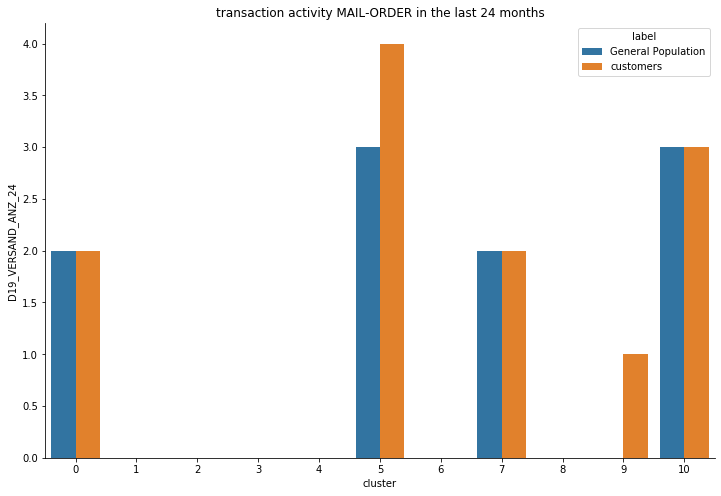

In [426]:
compare_col('D19_VERSAND_ANZ_24')

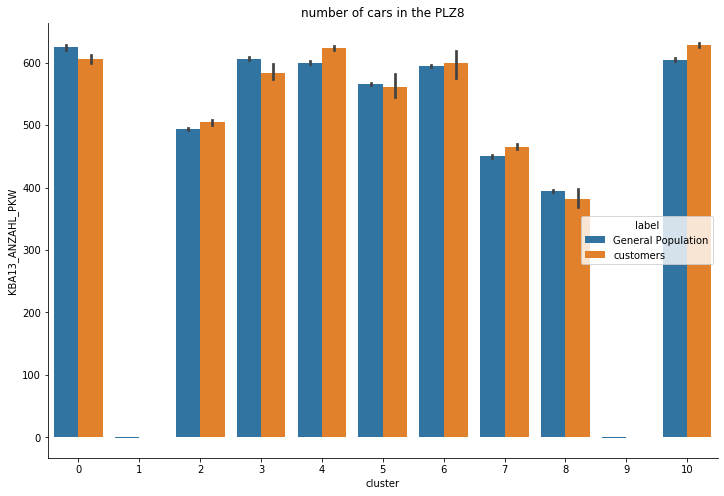

In [427]:
compare_col('KBA13_ANZAHL_PKW')

In [362]:
final_kmeans.cluster_centers_.shape

(11, 47)

Since we have only 11 clusters, we will see how they compare to our top 11 components:

In [380]:
clust_comp = pd.DataFrame(final_kmeans.cluster_centers_[:,:11], columns=['c_'+str(i) for i in range(1,12)])
clust_comp

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11
0,-1.141618,0.937304,0.102961,0.468630,-0.611561,0.490860,-0.009711,0.252295,0.023138,-0.172422,-0.065812
1,7.662320,0.017429,-0.019888,0.001130,-0.089469,0.088397,-0.467676,-0.331500,0.027713,-0.178364,-0.220032
2,-0.795926,-1.259008,-0.950759,0.867085,0.103504,-0.275735,0.022633,0.013741,0.100228,-0.010483,0.130198
3,-0.860418,-1.021947,0.049239,-0.955629,0.366784,0.415285,0.067238,0.171359,0.089774,0.022037,0.014339
4,-0.958396,-0.026595,-1.372505,-0.498549,-0.095432,-0.069813,0.103112,-0.021740,-0.075441,-0.124817,-0.092405
5,-1.192316,1.429841,1.606188,0.334899,-0.332707,-0.127390,-0.303652,0.050023,0.004124,0.060657,0.134707
6,-0.743064,-1.181652,0.726676,-0.207073,-1.105439,-0.032435,0.101320,-0.092669,-0.023671,-0.018554,0.091193
7,-1.153287,0.591265,0.470988,0.991301,1.071868,0.102528,-0.271381,0.158687,-0.036794,0.009388,-0.016500
8,-0.708056,-1.544881,1.146025,0.156993,0.746977,-0.270791,0.111072,-0.206066,-0.064958,0.116695,-0.155765
9,6.014273,1.371292,0.082450,0.081428,0.385824,-0.122009,1.624259,1.085981,-0.173540,0.513910,0.699747


Text(87.0, 0.5, 'clusters')

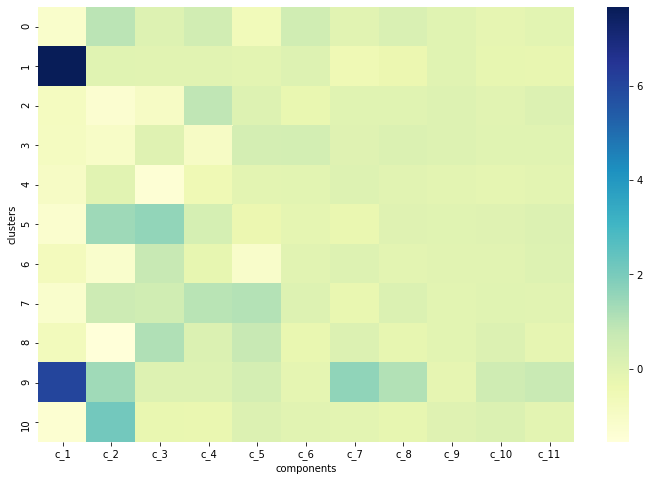

In [381]:
clust_comp = pd.DataFrame(final_kmeans.cluster_centers_[:,:11], columns=['c_'+str(i) for i in range(1,12)])
plt.figure(figsize=(12,8))
sns.heatmap(clust_comp, cmap = 'YlGnBu')
plt.xlabel('components')
plt.ylabel('clusters')

We can see that component 1 is mostly grouped into clusters 9 and 1 here

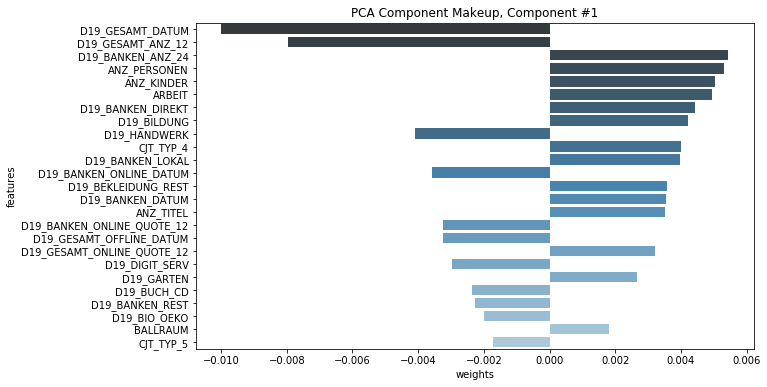

In [383]:
display_component(v,genpop.columns.values, component_num=1, n_weights=25)

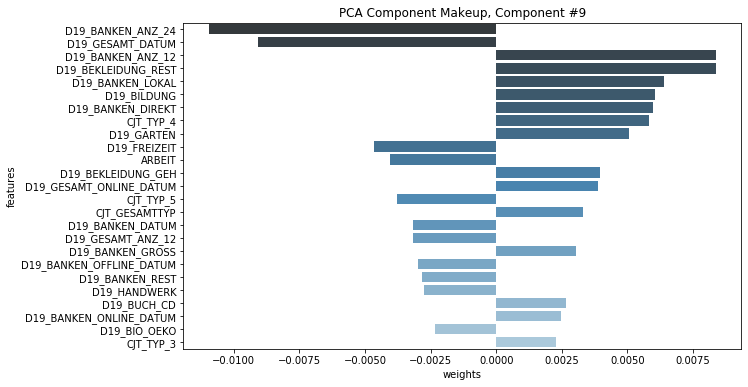

In [395]:
display_component(v,genpop.columns.values, component_num=9, n_weights=25)

And looking at these it makes sense, since the components look similar.

## Part 2: Supervised Learning Model

In [4]:
train_data = load_pickle('train.csv')
test_data = load_pickle('test.csv')

train.csv loaded!
test.csv loaded!


In [5]:
train_data.columns[~train_data.columns.isin(test_data.columns)]

Index(['RESPONSE', 'date_1992'], dtype='object')

First let's deal with the extra columns in train, that are not in test set

In [6]:
y_actual = train_data.RESPONSE

In [7]:
train_data = train_data.drop(['date_1992','RESPONSE'],axis=1)

Next we split the train so that we can evaluate our future models (test set will only be used to submit to Kaggle)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_data, y_actual, test_size = 0.2, stratify=y_actual, random_state=321)

Same Preprocessing steps here. Note that we have to scale the numbers to be from 0 to 1 for later, since that's what our loss function for pytorch wants.

In [93]:
def preprocess(X_train, X_val):
    rob = RobustScaler()
    scaler = MinMaxScaler((0,1))

    X_scaled = rob.fit_transform(X_train)
    X_scaled = scaler.fit_transform(X_scaled)

    Val_scaled = rob.transform(X_val)
    Val_scaled = scaler.transform(Val_scaled)

#     pca = PCA(n_components=47 , random_state = 321)
#     X = pca.fit_transform(X_scaled)
#     val = pca.transform(Val_scaled)
    
#     X = scaler.fit_transform(X)
#     val = scaler.transform(val)
    
    return X_scaled, Val_scaled

In [94]:
X, val = preprocess(X_train, X_val)

In [95]:
train_submit, test_submit = preprocess(train_data, test_data)

Now we'll use a basic model to get a base prediction.

In [95]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(verbose= 2, random_state=321, class_weight='balanced_subsample')

In [96]:
classifier.fit(X, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   16.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=321, verbose=2, warm_start=False)

In [97]:
val_predict = classifier.predict(val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [13]:
def evaluate_model(y_true, y_predict):
    print(confusion_matrix(y_true, y_predict))
    print()
    print(classification_report(y_true, y_predict))
    print()
    print(roc_auc_score(y_true, y_predict))

In [99]:
evaluate_model(y_val, val_predict)

[[8487    0]
 [ 106    0]]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8487
           1       0.00      0.00      0.00       106

    accuracy                           0.99      8593
   macro avg       0.49      0.50      0.50      8593
weighted avg       0.98      0.99      0.98      8593


0.5


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Well, even with the balanced setting for class_weight, a basic RandomForest completely fails to predict any positives for our dataset. We will need to keep that in mind when developing our Neural Network.

In [96]:
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # first column is the labels and rest is features 
    pd.concat([pd.DataFrame(y.values), pd.DataFrame(x)], axis=1)\
             .to_csv(os.path.join(data_dir, filename), header=False, index=False)
    
    # nothing is returned, but a print statement indicates that the function has run
    print('Path created: '+str(data_dir)+'/'+str(filename))

In [97]:
data_dir = 'alldata' # the folder we will use for storing data

make_csv(X, y_train, 'train.csv', data_dir)
make_csv(val, y_val, 'validation.csv', data_dir)
make_csv(train_submit, y_actual, 'train_submit.csv', data_dir)

pd.DataFrame(test_submit).to_csv(os.path.join(data_dir, 'test_submit.csv'), header=False, index=False)
print('Path created: '+str('alldata')+'/'+str('test_submit.csv'))

Path created: alldata/train.csv
Path created: alldata/validation.csv
Path created: alldata/train_submit.csv
Path created: alldata/test_submit.csv


In [33]:
y_train.value_counts(normalize=False)

0    33943
1      426
Name: RESPONSE, dtype: int64

In [19]:
33943/ 426

79.67840375586854

Thee ratio of 0 to 1 for our target response is 80:1

In [24]:
# specify where to upload in S3
prefix = 'predictions'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-1-615355522549/predictions


In [33]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='pytorch', 
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 47,  # num of features
                        'hidden_dim': 300,
                        'output_dim': 1,
                        'epochs': 100,
                        'batch-size':32,
                        'lr':0.00075,
                    })

In [137]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-01-29 22:59:54 Starting - Starting the training job...
2021-01-29 22:59:57 Starting - Launching requested ML instances.........
2021-01-29 23:01:29 Starting - Preparing the instances for training...
2021-01-29 23:02:17 Downloading - Downloading input data.........
2021-01-29 23:03:54 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-01-29 23:03:56,709 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-01-29 23:03:56,711 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-29 23:03:56,723 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-01-29 23:03:56,724 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-01-29 23:03:57,931 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generatin

Epoch: 32, BCELoss: 0.2533776505949885
Epoch: 33, BCELoss: 0.2449471685428952
Epoch: 34, BCELoss: 0.2457574179699265
Epoch: 35, BCELoss: 0.24057517396849254
Epoch: 36, BCELoss: 0.23809931876874246
Epoch: 37, BCELoss: 0.2335272075720998
Epoch: 38, BCELoss: 0.2284185224424961
Epoch: 39, BCELoss: 0.237098350764014
Epoch: 40, BCELoss: 0.23029417940675345
Epoch: 41, BCELoss: 0.2284283225550208
Epoch: 42, BCELoss: 0.22372446595236312
Epoch: 43, BCELoss: 0.22111932520256486
Epoch: 44, BCELoss: 0.21737672924320958
Epoch: 45, BCELoss: 0.22435400930601496
Epoch: 46, BCELoss: 0.2187884194802406
Epoch: 47, BCELoss: 0.2196769341064054
Epoch: 48, BCELoss: 0.22108876407146455
Epoch: 49, BCELoss: 0.21085761776150658
Epoch: 50, BCELoss: 0.20565725750541639
Epoch: 51, BCELoss: 0.21140681782853113
Epoch: 52, BCELoss: 0.2150461283438774
Epoch: 53, BCELoss: 0.20795301616365133
Epoch: 54, BCELoss: 0.2027070484955817
Epoch: 55, BCELoss: 0.2049932799853796
Epoch: 56, BCELoss: 0.2002151448271294
Epoch: 57, BCE

In [138]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='pytorch')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [139]:
%%time

# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.xlarge')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!CPU times: user 374 ms, sys: 4.59 ms, total: 378 ms
Wall time: 7min 32s


In [140]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [141]:
predictions = predict(val)
predictions = [round(num) for num in predictions]

In [142]:
set(predictions)

{0, 1}

In [143]:
evaluate_model(y_val ,predictions)

[[8231  256]
 [ 102    4]]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8487
           1       0.02      0.04      0.02       106

    accuracy                           0.96      8593
   macro avg       0.50      0.50      0.50      8593
weighted avg       0.98      0.96      0.97      8593


0.5037860345789676


In [144]:
boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)

{'ResponseMetadata': {'RequestId': '8bb09873-9334-4332-963e-f3d7b85309c1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8bb09873-9334-4332-963e-f3d7b85309c1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 29 Jan 2021 23:36:07 GMT'},
  'RetryAttempts': 0}}

Good news is it's not predicting all 0s anymore. Bad news is that our roc-auc score isn't getting any better. So, now it's time for optimization!

In [98]:
train_location  = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), bucket=bucket, key_prefix=prefix)
val_location  = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), bucket=bucket, key_prefix=prefix)
train_submit  = sagemaker_session.upload_data(os.path.join(data_dir, 'train_submit.csv'), bucket=bucket, key_prefix=prefix)
test_submit  = sagemaker_session.upload_data(os.path.join(data_dir, 'test_submit.csv'), bucket=bucket, key_prefix=prefix)

In [99]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').


In [100]:
xgb = sagemaker.estimator.Estimator(container,
                                    role,                                  
                                    train_instance_count=1,                 
                                    train_instance_type='ml.c5.2xlarge',     
                                    output_path=output_path,
                                    sagemaker_session=sagemaker_session)

xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='binary:logistic',
                        early_stopping_rounds=20,
                        num_round=500,
                        scale_pos_weight = 80,
                        seed = 321,
                        alpha = 2)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


It is recommended that we choose scale_pos_weight consisting of sum(negative cases) / sum(positive cases), which is 33943/ 426 for which turns out to be about 80.

In [103]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb,
                                               objective_metric_name = 'validation:auc',
                                               objective_type = 'Maximize', 
                                               max_jobs = 90,
                                               max_parallel_jobs = 3,
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(1, 10),
                                                    'alpha': IntegerParameter(0, 10),
                                                    'lambda': IntegerParameter(0, 15),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

Default search strategy is strategy Bayesian optimization, so we don't need to change it

In [104]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [105]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [ ]:
xgb_hyperparameter_tuner.wait()

..................................................................................................................

In [107]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2021-01-30 20:48:32 Starting - Preparing the instances for training
2021-01-30 20:48:32 Downloading - Downloading input data
2021-01-30 20:48:32 Training - Training image download completed. Training in progress.
2021-01-30 20:48:32 Uploading - Uploading generated training model
2021-01-30 20:48:32 Completed - Training job completedArguments: train
[2021-01-30:20:48:14:INFO] Running standalone xgboost training.
[2021-01-30:20:48:14:INFO] Setting up HPO optimized metric to be : auc
[2021-01-30:20:48:14:INFO] File size need to be processed in the node: 99.75mb. Available memory size in the node: 7733.15mb
[2021-01-30:20:48:14:INFO] Determined delimiter of CSV input is ','
[20:48:14] S3DistributionType set as FullyReplicated
[20:48:14] 34369x373 matrix with 12819637 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-01-30:20:48:15:INFO] Determined delimiter of CSV input is ','
[20:48:15] S3DistributionType set as FullyReplicated
[20:48:15] 8593x373 ma

In [108]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [109]:
xgb_transformer.transform(test_submit, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

..............................
2021-01-30T21:20:54.108:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2021-01-30 21:20:54 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2021-01-30 21:20:54 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-01-30 21:20:54 +0000] [1] [INFO] Using worker: gevent
[2021-01-30 21:20:54 +0000] [36] [INFO] Booting worker with pid: 36
[2021-01-30 21:20:54 +0000] [37] [INFO] Booting worker with pid: 37
[2021-01-30 21:20:54 +0000] [38] [INFO] Booting worker with pid: 38
Arguments: serve
[2021-01-30 21:20:54 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2021-01-30 21:20:54 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-01-30 21:20:54 +0000] [1] [INFO] Using worker: gevent
[2021-01-30 21:20:54 +0000] [36] [INFO] Booting worker with pid: 36
[2021-01-30 21:20:54 +0000] [37] [INFO] Booting worker with pid: 37
[2021-01-30 21:20:54 +0000] [38] [INFO] Booting worker with pid: 38
[2021-01-30

In [110]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-615355522549/xgboost-210130-1919-083-8f7a40bc-2021-01-30-21-16-01-214/test_submit.csv.out to alldata/test_submit.csv.out


In [111]:
predictions = pd.read_csv(os.path.join(data_dir, 'test_submit.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [ ]:
# boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)

## Part 3: Kaggle Competition

Now that we've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If we click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), we'll be taken to the competition page.

In [114]:
original_test = read_file('Udacity_MAILOUT_052018_TEST.csv')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [115]:
submitting = pd.concat([original_test.LNR, pd.Series(predictions, name = 'RESPONSE')], axis=1)

In [116]:
submitting.to_csv('submitting.csv', index=False)